<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/10_time_series_forecasting_with_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-04 20:47:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-03-04 20:47:06 (6.54 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples.

A smaller number of samples is something you'll often run into  with time series data problems. 

> 🔑 **Note:** The **seasonality** of time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.



In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


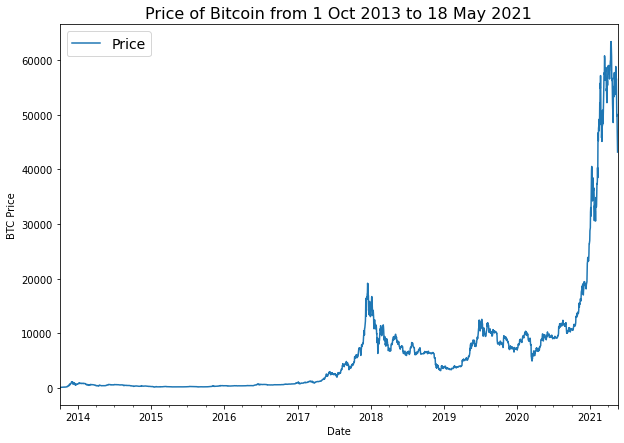

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [6]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

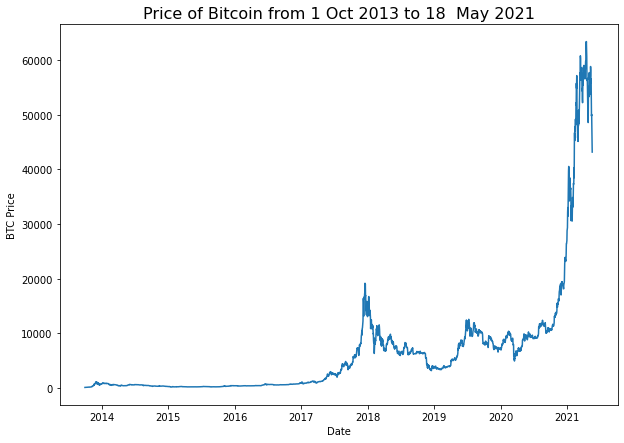

In [7]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps,
         btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18  May 2021", fontsize=16)
plt.xlabel("Date");


## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [8]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [9]:
# Wrong way to make train/test sets for timeseries data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

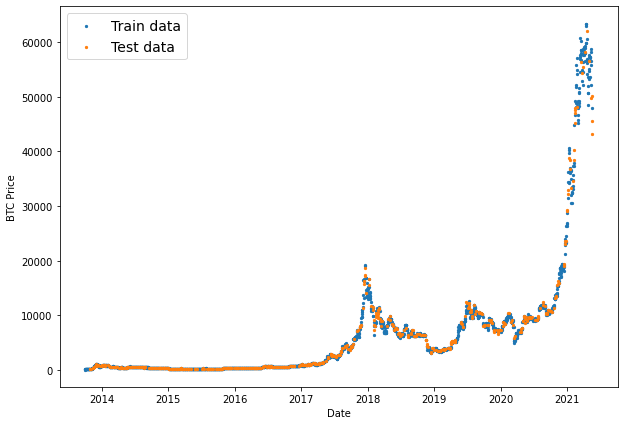

In [10]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)


In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

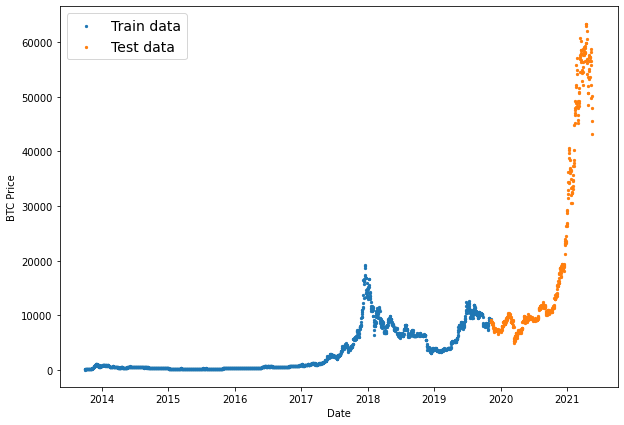

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

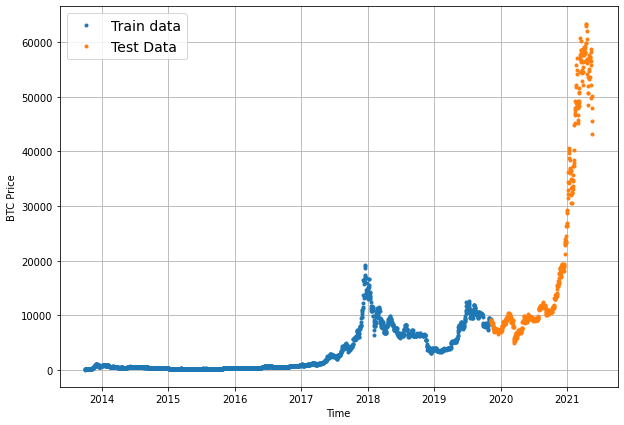

In [14]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)


## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

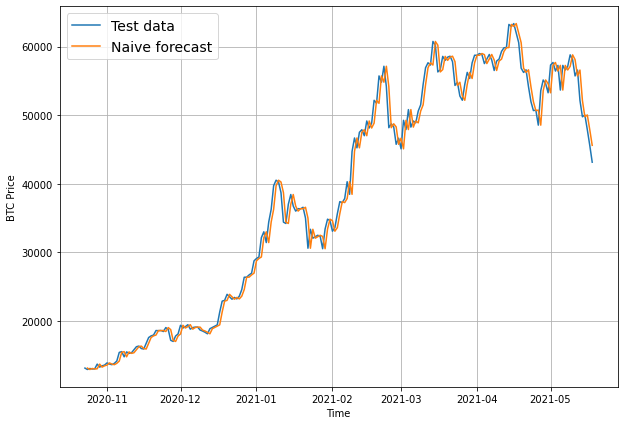

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

> ⚒️ **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. An have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up?

from IPython.core.magic import error
## Evaluating a time series model

Let's take into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that mean we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RSME - root mean suare error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
+ MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than a MAE of 100.

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
import tensorflow as tf

In [26]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates the mean absolute scaled error (MASE) between true and predicted values.

  The MASE measures the relative performance of a forecasting model compared to a naive (naïve2) forecast.
  The MASE is a scaling factor that scales the mean absolute error (MAE) of the forecast to account for the scale
  of the data and the forecast horizon. A MASE of 1 indicates that the forecasting model performs as well as a
  naive forecast, while a MASE < 1 indicates that the model outperforms the naive forecast.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A scalar value representing the MASE between y_true and y_pred.
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae / mae_naive_no_season

In [21]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [24]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [25]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [27]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [28]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [29]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [31]:
len(y_train)

2229

In [34]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [35]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use past week of Bitcoin data to make the prediction


In [50]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
    Given a data matrix 'x', return a pair of matrices containing labelled and windowed segments of the data.

    Parameters:
        - x (ndarray): A 2-dimensional matrix of shape (T, D), where T is the number of timesteps and
          D is the number of dimensions.
        - horizon (int): The number of timesteps to include in the window.
        
    Returns:
        - A tuple containing two 2-dimensional matrices of shape (T - horizon, horizon) and (T - horizon, 1),
          respectively. The first matrix contains the windowed segments of the input data, and the second matrix
          contains the labels that correspond to each window.
  """
  return x[:, :-horizon], x[:, -horizon:]

In [51]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 5, 6],
[1, 2, 3, 5, 6, 7],
[2, 3, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [55]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Creates windowed data from a target time series.

  Parameters:
      - x (ndarray): A 1-dimensional array containing the target time series.
      - window_size (int): The size of the window to use to create the data (default: WINDOW_SIZE).
      - horizon (int): The number of timesteps into the future to predict (default: HORIZON).

  Returns:
      - A tuple containing two 2-dimensional arrays of shape (N, window_size) and (N, horizon),
        respectively. The first array contains the windowed segments of the input data, and the
        second array contains the labels that correspond to each window.

  Example usage:
  ```python
  # Load some example data
  target_series = np.loadtxt('target_series.txt')

  # Create windowed data with a window size of 30 and a horizon of 1
  X, y = make_windows(target_series, window_size=30, horizon=1)
  ```
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (a time series) with 2D araay of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [56]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [57]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [59]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]
